# 2D diffusion using FEM

Problem description:

We will solve for the steady-state temperature field within a unit square box. The box includes a rectangular region in the center, where conductivity is higher. If you want geological context, think of it as a salt diapir ;)

Setup:

center coordinate: 0,0
length in x and : 1
top temperature: 0
bot temperature: 1
thermal conductivity: 1
box conductivity: 5

In [1]:
import numpy as np
from tabulate import tabulate
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy import sparse
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300

In [2]:
#geometry
lx          = 2
ly          = 1
nx          = 31
ny          = 21
nnodel      = 4
dx          = lx/(nx-1)
dy          = ly/(ny-1)
w_i         = 0.2 # width inclusion
h_i         = 0.2 # heigths inclusion

# model parameters
k1          = 1
k2          = 5
Ttop        = 0
Tbot        = 1
 
nex         = nx-1
ney         = ny-1
nnod        = nx*ny
nel         = nex*ney
GCOORD      = np.zeros((nnod,2))
T           = np.zeros(nnod) #initial T

id = 0

# global coordinates

for i in range(0,ny):
    for j in range(0,nx):
        GCOORD[id,0] = -lx/2 + j*dx
        GCOORD[id,1] = -ly/2 + i*dy
        id          = id + 1;

# FEM connectivity
EL2NOD   = np.zeros((nel,nnodel), dtype=int)

for iel in range(0,nel):
    row        = iel//nex   
    ind        = iel + row
    EL2NOD[iel,:] = [ind, ind+1, ind+nx+1, ind+nx]
    
# Gauss integration points
nip   = 4
gauss = np.array([[ -np.sqrt(1/3), np.sqrt(1/3), np.sqrt(1/3), -np.sqrt(1/3)], [-np.sqrt(1/3), -np.sqrt(1/3), np.sqrt(1/3), np.sqrt(1/3)]]).T.copy()


Now we create our shape functions

In [3]:
def shapes():
    
    #shape functions
    
    N1 = 0.25*(1-xi)*(1-eta)
    N2 = 0.25*(1+xi)*(1-eta)
    N3 = 0.25*(1+xi)*(1+eta)
    N4 = 0.25*(1-xi)*(1+eta)

    N = np.array([N1, N2, N3, N4])
    
    # and their derivatives
    dNds = np.zeros((2,4))
 
    dNds[0,0]   =  0.25*(-1  + eta) #derivative with xi
    dNds[1,0]   =  0.25*(xi  -  1) #derivative with eta

    #derivatives of second shape function with local coordinates
    dNds[0,1]   =  0.25*(1   - eta)
    dNds[1,1]   =  0.25*(-xi -  1)

    #derivatives of third shape function with local coordinates
    dNds[0,2]   =  0.25*(eta  +  1)
    dNds[1,2]   =  0.25*(xi  +  1)

    #derivatives of fourth shape function with local coordinates
    dNds[0,3]   =  0.25*(-eta -  1)
    dNds[1,3]   =  0.25*(1   - xi)
    
    return N, dNds

And do the element assembly and integration

In [4]:
Rhs_all = np.zeros(nnod)

I = np.zeros((nel,nnodel*nnodel))
J = np.zeros((nel,nnodel*nnodel))
K = np.zeros((nel,nnodel*nnodel))

for iel in range(0,nel):
    ECOORD = np.take(GCOORD, EL2NOD[iel,:], axis=0 )
    Ael    = np.zeros((nnodel,nnodel))
    Rhs_el = np.zeros(nnodel)
    
    for ip in range(0,nip):
        
        # 1. update shape functions
        xi      = gauss[ip,0]
        eta     = gauss[ip,1]
        N, dNds = shapes()
        
        # 2. set up Jacobian, inverse of Jacobian, and determinant
        Jac     = np.matmul(dNds,ECOORD) #[2,nnodel]*[nnodel,2]
        invJ    = np.linalg.inv(Jac)    
        detJ    = np.linalg.det(Jac)
        
        # 3. get global derivatives
        dNdx    = np.matmul(invJ, dNds) # [2,2]*[2,nnodel]
        
        # 4. compute element stiffness matrix
        Ael     = Ael + np.matmul(dNdx.T, dNdx)*detJ*k1 # [nnodel,1]*[1,nnodel]
        
        # 5. assemble right-hand side
        Rhs_el     = Rhs_el + np.zeros(4)
    
    # assemble coefficients
    I[iel,:]  =  (EL2NOD[iel,:]*np.ones((nnodel,1), dtype=int)).T.reshape(nnodel*nnodel)
    J[iel,:]  =  (EL2NOD[iel,:]*np.ones((nnodel,1), dtype=int)).reshape(nnodel*nnodel)
    K[iel,:]  =  Ael.reshape(nnodel*nnodel)
    
    Rhs_all[EL2NOD[iel,:]] += Rhs_el


A_all = sparse.csr_matrix((K.reshape(nel*nnodel*nnodel),(I.reshape(nel*nnodel*nnodel),J.reshape(nel*nnodel*nnodel))),shape=(nnod,nnod))



Boundary conditions and solution

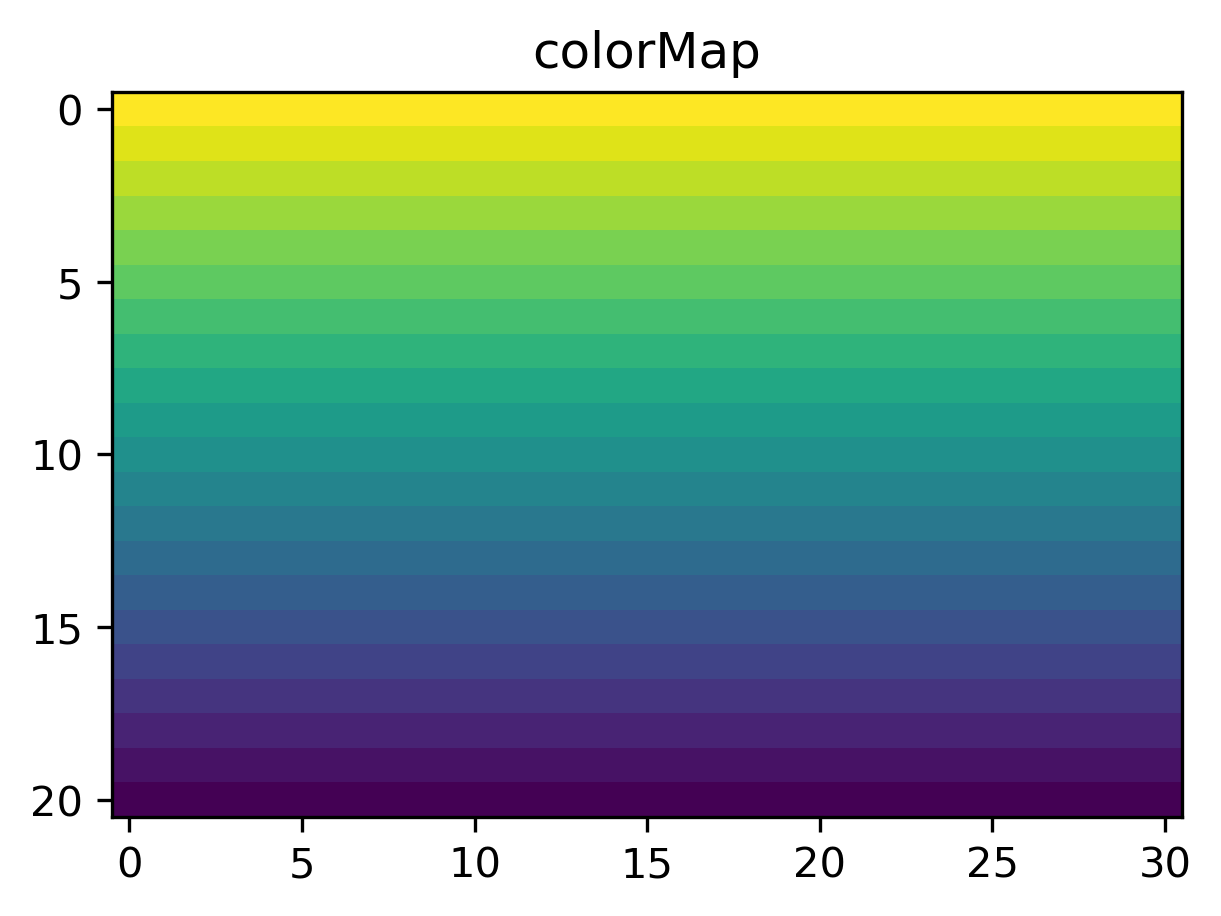

In [5]:
# indices and values at top and bottom
i_bot   = np.arange(0,nx, dtype=int)
i_top   = np.arange(nx*(ny-1),nx*ny, dtype=int)
Ind_bc  = np.concatenate((i_bot, i_top))
Val_bc  = np.concatenate((np.ones(i_bot.shape)*Tbot, np.ones(i_top.shape)*Ttop ))

# smart way of boundary conditions that keeps matrix symmetry
Free    = np.arange(0,nnod)
Free    = np.delete(Free, Ind_bc)
TMP     = A_all[:,Ind_bc]

Rhs_all = Rhs_all - TMP.dot(Val_bc)

# solve reduced system
T[Free] = spsolve(A_all[np.ix_(Free, Free)],Rhs_all[Free])
T[Ind_bc] = Val_bc


# plottin
T = T.reshape((ny,nx))

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(T)
ax.set_aspect('equal')



In [6]:
print(is_sym)

True
